In [17]:
import numpy as np
import matplotlib.pyplot as plt
import arrow
import datetime
import xarray as xr
import os
import cmocean.cm as cm
import matplotlib.cm as cma
import scipy.interpolate as interp
from matplotlib.collections import PatchCollection
import matplotlib.dates as mpl_dates
from matplotlib.ticker import ScalarFormatter
from matplotlib.ticker import FormatStrFormatter
import datetime as dt 
from matplotlib.patches import Rectangle
from IPython.display import Image, display
import pandas as pd
from salishsea_tools import viz_tools, places, visualisations

### Functions

In [2]:
variables = ['final_salt','final_transp','final_lon','final_lat','final_depth','final_section','final_z','final_temp','init_lon','init_z','init_salt','init_temp','init_transp','final_age','final_dens','init_dens','init_lat']

#Function to extract data from 1 section
def get_secdata(datafile,sectionnum):
    
    variables = ['final_salt','final_transp','final_lon','final_lat','final_depth','final_section','final_z','final_temp','init_lon','init_z','init_salt','init_temp','init_transp','final_age','final_dens','init_dens','init_lat']
    
    dict_var = {}
    
    idx = np.where(datafile['final_section']==sectionnum)
    
    for var in variables:
        if var == 'final_age':
            agetd = datafile[var].values
            agehr = agetd.astype('float64')/(10**9*3600)
            age = agehr[idx]
            dict_var[var] = xr.DataArray(age)
        else:
            data_sec = datafile[var]
            dict_var[var] = data_sec[idx]
        
    
    return dict_var      

def draw_patches(fmask, ll, ul, u_lons, w_depths,m2lon):
    topo = []
    for i in range(ll, ul):
        for j in range(39):
            if fmask[j, i] == 0:
                try:
                    rect = Rectangle((u_lons[i]/m2lon, w_depths[j+1]), u_lons[i+1]/m2lon-u_lons[i]/m2lon, w_depths[j+2]-w_depths[j+1])
                    topo.append(rect)
                except:
                    pass

    pc = PatchCollection(topo, facecolors='lightgray', edgecolors='none')
    return(pc)


def plotTS(axn,var,lonsec,zsec,varsec,lonW,lonE,latgridi,depi,time,title,cblabel,ylabel,vmin=None,vmax=None):
    
    latgridf = latgridi-1
    fmask = mesh.fmask[0, :, latgridf]
    tmask = mesh.tmask[0]
    
    lons = data.init_lon[(data.final_section != 0)]
    
    f_lons = mesh.glamf[0, latgridf]
    u_lons = mesh.glamv[0, latgridf]
    w_depths = mesh.gdepw_1d

    m2lon = ((u_lons[lonE]-u_lons[lonW])/(mesh.e2f[0, latgridi, lonW:lonE].sum())).values #degrees/m
    
    cmap = cm.deep
    
    m2lon = ((u_lons[lonE]-u_lons[lonW])/(mesh.e2f[0, latgridi, lonW:lonE].sum())).values #degrees/m
    
    arrw,xe,ye,im = axn.hist2d(lonsec/m2lon,df(zsec)[0],weights=varsec,cmap=cmap,bins=[np.array(f_lons[lonW:lonE:1]/m2lon),w_depths[0,0:depi]])
    arrnw,xe2,ye2,im2 = axn.hist2d(lonsec/m2lon,df(zsec)[0],cmap=cmap,bins=[np.array(f_lons[lonW:lonE:1]/m2lon),w_depths[0,0:depi]])
    
    arr3 = arrw/arrnw
    
    X,Y = np.meshgrid(xe,ye)
    
    im = axn.pcolormesh(X,Y,arr3.T,vmin=vmin,vmax=vmax)
    axn.set_xlabel('Longitude (°E)')
    axn.set_title(title)
    axn.invert_yaxis()
    axn.set_xticks(np.linspace(f_lons[lonW]/m2lon,f_lons[lonE-1]/m2lon,2))
    axn.set_xticklabels(['{:.2f}'.format(label) for label in np.linspace(f_lons[lonW],f_lons[lonE-1],2)])
    
    if cblabel == True:
        cb = fig.colorbar(im,ax=axn)
        
        if var == 'temp':
            cb.set_label('Temperature (°C)')
        if var == 'sal':
            cb.set_label('Salinity (g/kg)')
            
    if ylabel == True:
        axn.set_ylabel('Depth (m)')
    else:
        axn.set_yticks([])
        
def get_datat(datafile,section, starttime, endtime):
    final_section = datafile.final_section
    final_transport = datafile.final_transp
    transports = np.sum(np.where(final_section == section, final_transport, 0)) 
    return transports/(endtime-starttime+1)

### Import data

In [3]:
data = xr.open_dataset('/ocean/cstang/MOAD/analysis-camryn/Ariane/for_jan18/for_straight_01jan18_s7t28/ariane_positions_quantitative.nc')
mesh = xr.open_dataset('/home/sallen/MEOPAR/grid/mesh_mask202108.nc')
df = interp.interp1d(mesh.z,mesh.gdepw_1d) # Interpolate to get same binning scheme as SalishSeaCast

In [4]:
#Importing data and calculating section transport 
import warnings
warnings.filterwarnings('ignore', category=RuntimeWarning)

# files = ['forpr_ros3','forpr_haro3','forvs_haro3']
files = ['forpr_sjc3','forgulf_sjc3','forvs_sjc3','foradm_sjc3','forpr_ros3','forgulf_ros3','forvs_ros3','foradm_ros3',
         'forpr_haro3','forgulf_haro3','forvs_haro3','foradm_haro3']
namen = ['datafvs']

starttime = 1
endtime = 24
sectionnum = [0,1,2,3,4,5,6,7,8]

date = dt.datetime(2018,1,1)
enddate = dt.datetime(2018,12,31)

dates = []
datelist_vs = []

while date <= enddate:
    dates.append(date.strftime('%d%b%y').lower())
    datelist_vs.append(date)
    date+=dt.timedelta(days=1)
     
dicts = {}

for i,file in enumerate(files):
    dict_i = {}
    
    for date in dates:
        name = '/ocean/cstang/MOAD/analysis-camryn/Ariane/' + file + '/' + date + '_s1t50/ariane_positions_quantitative.nc'
        
        if os.path.isfile(name):
            dict_i[date] = xr.open_dataset(name)
        
    dicts[file] = dict_i
    
dict_sectiontransp = {}

for file in files:
    st_dict = {}
    for section in sectionnum:
        if section not in st_dict:
            st_dict[section] = []
            
        for date in dates:
            try:
                st_dict[section].append(get_datat(dicts[file][date],section,starttime,endtime))
            except:
                print(date)
                pass 
        dict_sectiontransp[file] = st_dict


28may18
28may18
28may18
28may18
28may18
28may18
28may18
28may18
28may18


In [6]:
prtovs_sjc_365 = np.insert(dict_sectiontransp['forpr_sjc3'][5], 147, np.nan)
prtoadm_sjc_365 = np.insert(dict_sectiontransp['forpr_sjc3'][2], 147, np.nan)
prtogulf_sjc_365 = np.insert(dict_sectiontransp['forpr_sjc3'][7], 147, np.nan)

#forpr_sjc
prtovs_sjc = pd.DataFrame({'Transport':prtovs_sjc_365},index=datelist_vs)
prtoadm_sjc = pd.DataFrame({'Transport':prtoadm_sjc_365},index=datelist_vs)
prtogulf_sjc = pd.DataFrame({'Transport':prtogulf_sjc_365},index=datelist_vs)

#forpr_haro
prtovs_haro = pd.DataFrame({'Transport':dict_sectiontransp['forpr_haro3'][6]},index=datelist_vs)
prtoadm_haro = pd.DataFrame({'Transport':dict_sectiontransp['forpr_haro3'][2]},index=datelist_vs)
prtogulf_haro = pd.DataFrame({'Transport':dict_sectiontransp['forpr_haro3'][7]},index=datelist_vs)

#forpr_ros
prtovs_ros = pd.DataFrame({'Transport':dict_sectiontransp['forpr_ros3'][4]},index=datelist_vs)
prtoadm_ros = pd.DataFrame({'Transport':dict_sectiontransp['forpr_ros3'][2]},index=datelist_vs)
prtogulf_ros = pd.DataFrame({'Transport':dict_sectiontransp['forpr_ros3'][7]},index=datelist_vs)

#forgulf_haro
gulftovs_haro = pd.DataFrame({'Transport':dict_sectiontransp['forgulf_haro3'][7]},index=datelist_vs)
gulftoadm_haro = pd.DataFrame({'Transport':dict_sectiontransp['forgulf_haro3'][2]},index=datelist_vs)
gulftopr_haro = pd.DataFrame({'Transport':dict_sectiontransp['forgulf_haro3'][6]},index=datelist_vs)

#forgulf_ros
gulftovs_ros = pd.DataFrame({'Transport':dict_sectiontransp['forgulf_ros3'][7]},index=datelist_vs)
gulftoadm_ros = pd.DataFrame({'Transport':dict_sectiontransp['forgulf_ros3'][2]},index=datelist_vs)
gulftopr_ros = pd.DataFrame({'Transport':dict_sectiontransp['forgulf_ros3'][4]},index=datelist_vs)

#forgulf_sjc
gulftovs_sjc = pd.DataFrame({'Transport':dict_sectiontransp['forgulf_sjc3'][7]},index=datelist_vs)
gulftoadm_sjc = pd.DataFrame({'Transport':dict_sectiontransp['forgulf_sjc3'][2]},index=datelist_vs)
gulftopr_sjc = pd.DataFrame({'Transport':dict_sectiontransp['forgulf_sjc3'][5]},index=datelist_vs)

#forvs_haro
vstogulf_haro = pd.DataFrame({'Transport':dict_sectiontransp['forvs_haro3'][7]},index=datelist_vs)
vstoadm_haro = pd.DataFrame({'Transport':dict_sectiontransp['forvs_haro3'][2]},index=datelist_vs)
vstopr_haro = pd.DataFrame({'Transport':dict_sectiontransp['forvs_haro3'][6]},index=datelist_vs)

#forvs_ros
vstogulf_ros = pd.DataFrame({'Transport':dict_sectiontransp['forvs_ros3'][7]},index=datelist_vs)
vstoadm_ros = pd.DataFrame({'Transport':dict_sectiontransp['forvs_ros3'][2]},index=datelist_vs)
vstopr_ros = pd.DataFrame({'Transport':dict_sectiontransp['forvs_ros3'][4]},index=datelist_vs)

#forvs_sjc
vstogulf_sjc = pd.DataFrame({'Transport':dict_sectiontransp['forvs_sjc3'][7]},index=datelist_vs)
vstoadm_sjc = pd.DataFrame({'Transport':dict_sectiontransp['forvs_sjc3'][2]},index=datelist_vs)
vstopr_sjc = pd.DataFrame({'Transport':dict_sectiontransp['forvs_sjc3'][5]},index=datelist_vs)

#foradm_haro
admtogulf_haro = pd.DataFrame({'Transport':dict_sectiontransp['foradm_haro3'][7]},index=datelist_vs)
admtovs_haro = pd.DataFrame({'Transport':dict_sectiontransp['foradm_haro3'][2]},index=datelist_vs)
admtopr_haro = pd.DataFrame({'Transport':dict_sectiontransp['foradm_haro3'][6]},index=datelist_vs)

#foradm_ros
admtogulf_ros = pd.DataFrame({'Transport':dict_sectiontransp['foradm_ros3'][7]},index=datelist_vs)
admtovs_ros = pd.DataFrame({'Transport':dict_sectiontransp['foradm_ros3'][2]},index=datelist_vs)
admtopr_ros = pd.DataFrame({'Transport':dict_sectiontransp['foradm_ros3'][4]},index=datelist_vs)

#foradm_sjc
admtogulf_sjc = pd.DataFrame({'Transport':dict_sectiontransp['foradm_sjc3'][7]},index=datelist_vs)
admtovs_sjc = pd.DataFrame({'Transport':dict_sectiontransp['foradm_sjc3'][2]},index=datelist_vs)
admtopr_sjc = pd.DataFrame({'Transport':dict_sectiontransp['foradm_sjc3'][5]},index=datelist_vs)

In [7]:
#foradm
admtopr_sjc_avg = admtopr_sjc.resample('M').mean()
admtovs_sjc_avg = admtovs_sjc.resample('M').mean()
admtogulf_sjc_avg = admtogulf_sjc.resample('M').mean()

admtopr_ros_avg = admtopr_ros.resample('M').mean()
admtovs_ros_avg = admtovs_ros.resample('M').mean()
admtogulf_ros_avg = admtogulf_ros.resample('M').mean()

admtopr_haro_avg = admtopr_haro.resample('M').mean()
admtovs_haro_avg = admtovs_haro.resample('M').mean()
admtogulf_haro_avg = admtogulf_haro.resample('M').mean()

#forvs
vstopr_sjc_avg = vstopr_sjc.resample('M').mean()
vstoadm_sjc_avg = vstoadm_sjc.resample('M').mean()
vstogulf_sjc_avg = vstogulf_sjc.resample('M').mean()

vstopr_haro_avg = vstopr_haro.resample('M').mean()
vstoadm_haro_avg = vstoadm_haro.resample('M').mean()
vstogulf_haro_avg = vstogulf_haro.resample('M').mean()

vstopr_ros_avg = vstopr_ros.resample('M').mean()
vstoadm_ros_avg = vstoadm_ros.resample('M').mean()
vstogulf_ros_avg = vstogulf_ros.resample('M').mean()

#forgulf
gulftopr_sjc_avg = gulftopr_sjc.resample('M').mean()
gulftoadm_sjc_avg = gulftoadm_sjc.resample('M').mean()
gulftovs_sjc_avg = gulftovs_sjc.resample('M').mean()

gulftopr_haro_avg = gulftopr_haro.resample('M').mean()
gulftoadm_haro_avg = gulftoadm_haro.resample('M').mean()
gulftovs_haro_avg = gulftovs_haro.resample('M').mean()

gulftopr_ros_avg = gulftopr_ros.resample('M').mean()
gulftoadm_ros_avg = gulftoadm_ros.resample('M').mean()
gulftovs_ros_avg = gulftovs_ros.resample('M').mean()

#forpr
prtogulf_sjc_avg = prtogulf_sjc.resample('M').mean()
prtoadm_sjc_avg = prtoadm_sjc.resample('M').mean()
prtovs_sjc_avg = prtovs_sjc.resample('M').mean()

prtogulf_haro_avg = prtogulf_haro.resample('M').mean()
prtoadm_haro_avg = prtoadm_haro.resample('M').mean()
prtovs_haro_avg = prtovs_haro.resample('M').mean()

prtogulf_ros_avg = prtogulf_ros.resample('M').mean()
prtoadm_ros_avg = prtoadm_ros.resample('M').mean()
prtovs_ros_avg = prtovs_ros.resample('M').mean()

## Balances

In [8]:
vstoadm_sjc_avg

,Transport
2018-01-31,21403.490464
2018-02-28,20573.058816
2018-03-31,20665.862951
2018-04-30,20629.782644
2018-05-31,18268.379314
2018-06-30,18561.165353
2018-07-31,19386.426497
2018-08-31,19602.280582
2018-09-30,20075.338353
2018-10-31,19979.869466


In [9]:
vstoadm_sjc_avg.iloc[0]

Transport    21403.490464
Name: 2018-01-31 00:00:00, dtype: float64

In [285]:
leave_vic = np.zeros_like(vstoadm_haro_avg)
ent_vic = np.zeros_like(vstoadm_haro_avg)
leave_adm = np.zeros_like(vstoadm_haro_avg)
ent_adm = np.zeros_like(vstoadm_haro_avg)
leave_gulf = np.zeros_like(vstoadm_haro_avg)
ent_gulf = np.zeros_like(vstoadm_haro_avg)
leave_pr = np.zeros_like(vstoadm_haro_avg)
ent_pr = np.zeros_like(vstoadm_haro_avg)
leave_total = np.zeros_like(vstoadm_haro_avg)
ent_total = np.zeros_like(vstoadm_haro_avg)

for i in range(12):
    leave_vic[i] = np.sum([np.mean([vstoadm_sjc_avg.Transport[i] ,vstoadm_haro_avg.Transport[i] ,vstoadm_ros_avg.Transport[i] ]),vstopr_ros_avg.Transport[i],vstogulf_ros_avg.Transport[i],vstopr_haro_avg.Transport[i],vstogulf_haro_avg.Transport[i],vstopr_sjc_avg.Transport[i],vstogulf_sjc_avg.Transport[i]])
    ent_vic[i] = np.sum([np.mean([admtovs_sjc_avg.Transport[i] ,admtovs_haro_avg.Transport[i] ,admtovs_ros_avg.Transport[i] ]),prtovs_ros_avg.Transport[i],gulftovs_ros_avg.Transport[i],prtovs_haro_avg.Transport[i],gulftovs_haro_avg.Transport[i],prtovs_sjc_avg.Transport[i],gulftovs_sjc_avg.Transport[i]])

    leave_adm[i] = np.sum([np.mean([admtovs_sjc_avg.Transport[i] ,admtovs_haro_avg.Transport[i] ,admtovs_ros_avg.Transport[i] ]),admtopr_ros_avg.Transport[i],admtogulf_ros_avg.Transport[i],admtopr_haro_avg.Transport[i],admtogulf_haro_avg.Transport[i],admtopr_sjc_avg.Transport[i],admtogulf_sjc_avg.Transport[i]])
    ent_adm[i] = np.sum([np.mean([vstoadm_sjc_avg.Transport[i] ,vstoadm_haro_avg.Transport[i] ,vstoadm_ros_avg.Transport[i] ]),prtoadm_ros_avg.Transport[i],gulftoadm_ros_avg.Transport[i],prtoadm_haro_avg.Transport[i],gulftoadm_haro_avg.Transport[i],prtoadm_sjc_avg.Transport[i],gulftoadm_sjc_avg.Transport[i]])
    
    leave_pr[i] = np.sum([np.mean([prtogulf_sjc_avg.Transport[i] ,prtogulf_haro_avg.Transport[i] ,prtogulf_ros_avg.Transport[i] ]),prtoadm_ros_avg.Transport[i],prtovs_ros_avg.Transport[i],prtoadm_haro_avg.Transport[i],prtovs_haro_avg.Transport[i],prtoadm_sjc_avg.Transport[i],prtovs_sjc_avg.Transport[i]])
    ent_pr[i] = np.sum([np.mean([gulftopr_sjc_avg.Transport[i] ,gulftopr_haro_avg.Transport[i] ,gulftopr_ros_avg.Transport[i] ]),admtopr_ros_avg.Transport[i],vstopr_ros_avg.Transport[i],admtopr_haro_avg.Transport[i],vstopr_haro_avg.Transport[i],admtopr_sjc_avg.Transport[i],vstopr_sjc_avg.Transport[i]])
    
    leave_gulf[i] = np.sum([np.mean([gulftopr_sjc_avg.Transport[i] ,gulftopr_haro_avg.Transport[i] ,gulftopr_ros_avg.Transport[i] ]),gulftoadm_ros_avg.Transport[i],gulftovs_ros_avg.Transport[i],gulftoadm_haro_avg.Transport[i],gulftovs_haro_avg.Transport[i],gulftoadm_sjc_avg.Transport[i],gulftovs_sjc_avg.Transport[i]])
    ent_gulf[i] = np.sum([np.mean([prtogulf_sjc_avg.Transport[i] ,prtogulf_haro_avg.Transport[i] ,prtogulf_ros_avg.Transport[i] ]),admtogulf_ros_avg.Transport[i],vstogulf_ros_avg.Transport[i],admtogulf_haro_avg.Transport[i],vstogulf_haro_avg.Transport[i],admtogulf_sjc_avg.Transport[i],vstogulf_sjc_avg.Transport[i]])

    leave_total[i] = np.sum([leave_vic[i],leave_pr[i],leave_adm[i],leave_gulf[i]])
    ent_total[i] = np.sum([ent_vic[i],ent_pr[i],ent_adm[i],ent_gulf[i]])

# print('Leaving VicSill:',leave_vic)
# print('Leaving PointRob:',leave_pr)
# print('Leaving Admiralty:',leave_adm)
# print('Leaving Gulf:',leave_gulf)
# print('Total:',leave_total,'\n')

# print('Entering Victoria:',ent_vic)
# print('Entering PointRob:',ent_pr)
# print('Entering Admiralty:',ent_adm)
# print('Entering Gulf:',ent_gulf)
# print('Total:',ent_total)

In [11]:
N_haro = np.sum([vstopr_haro_avg,vstogulf_haro_avg,admtogulf_haro_avg,admtopr_haro_avg],axis=0)
N_ros = np.sum([vstopr_ros_avg,vstogulf_ros_avg,admtogulf_ros_avg,admtopr_ros_avg],axis=0)
N_sjc = np.sum([vstopr_sjc_avg,vstogulf_sjc_avg,admtogulf_sjc_avg,admtopr_sjc_avg],axis=0)

# print(N_haro,N_ros,N_sjc)
print(ent_gulf+ent_pr)
#Check that whats going through each strait + whats going b/w pr and gulf is =
total = N_haro+N_ros+N_sjc+np.mean([prtogulf_haro_avg,prtogulf_ros_avg,prtogulf_sjc_avg])+np.mean([gulftopr_haro_avg,gulftopr_ros_avg,gulftopr_sjc_avg])
print(total)

[[24857.21334997]
 [33305.24878886]
 [31983.46062646]
 [30881.02408252]
 [38429.18768902]
 [47431.2694521 ]
 [56078.76499177]
 [54349.90242963]
 [50048.50336524]
 [44552.53004018]
 [31118.47226871]
 [24802.56528143]]
[[24934.71775805]
 [33699.30833619]
 [32629.66604364]
 [31338.15323426]
 [38224.33435295]
 [47514.63619533]
 [56116.17023357]
 [54240.28073035]
 [49181.22432782]
 [44266.61309775]
 [31389.85717005]
 [24303.18088594]]


In [290]:
S_haro = np.sum([prtovs_haro_avg,gulftovs_haro_avg,gulftoadm_haro_avg,prtoadm_haro_avg],axis=0)
S_ros = np.sum([prtovs_ros_avg,gulftovs_ros_avg,gulftoadm_ros_avg,prtoadm_ros_avg],axis=0)
S_sjc = np.sum([prtovs_sjc_avg,gulftovs_sjc_avg,gulftoadm_sjc_avg,prtoadm_sjc_avg],axis=0)

# print(N_haro,N_ros,N_sjc)
print(ent_adm+ent_vic)
#Check that whats going through each strait + whats going b/w pr and gulf is =
total = S_haro+S_ros+S_sjc+np.mean([vstoadm_haro_avg,vstoadm_ros_avg,vstoadm_sjc_avg])+np.mean([admtovs_haro_avg,admtovs_ros_avg,admtovs_sjc_avg])
print(total)

[[61548.44857577]
 [73940.20057754]
 [74159.82813091]
 [73770.80480098]
 [86927.12917877]
 [89320.39313812]
 [97553.15440909]
 [97044.17671236]
 [90109.41872615]
 [81003.72704146]
 [64047.89729116]
 [54731.42080156]]
[[65547.27337613]
 [72871.42436152]
 [72625.40699601]
 [73977.3017791 ]
 [84840.27702201]
 [85930.83441035]
 [92727.51562574]
 [92877.59650967]
 [87367.4452814 ]
 [80881.67014545]
 [68033.93422243]
 [66475.91965404]]


### Plotting 

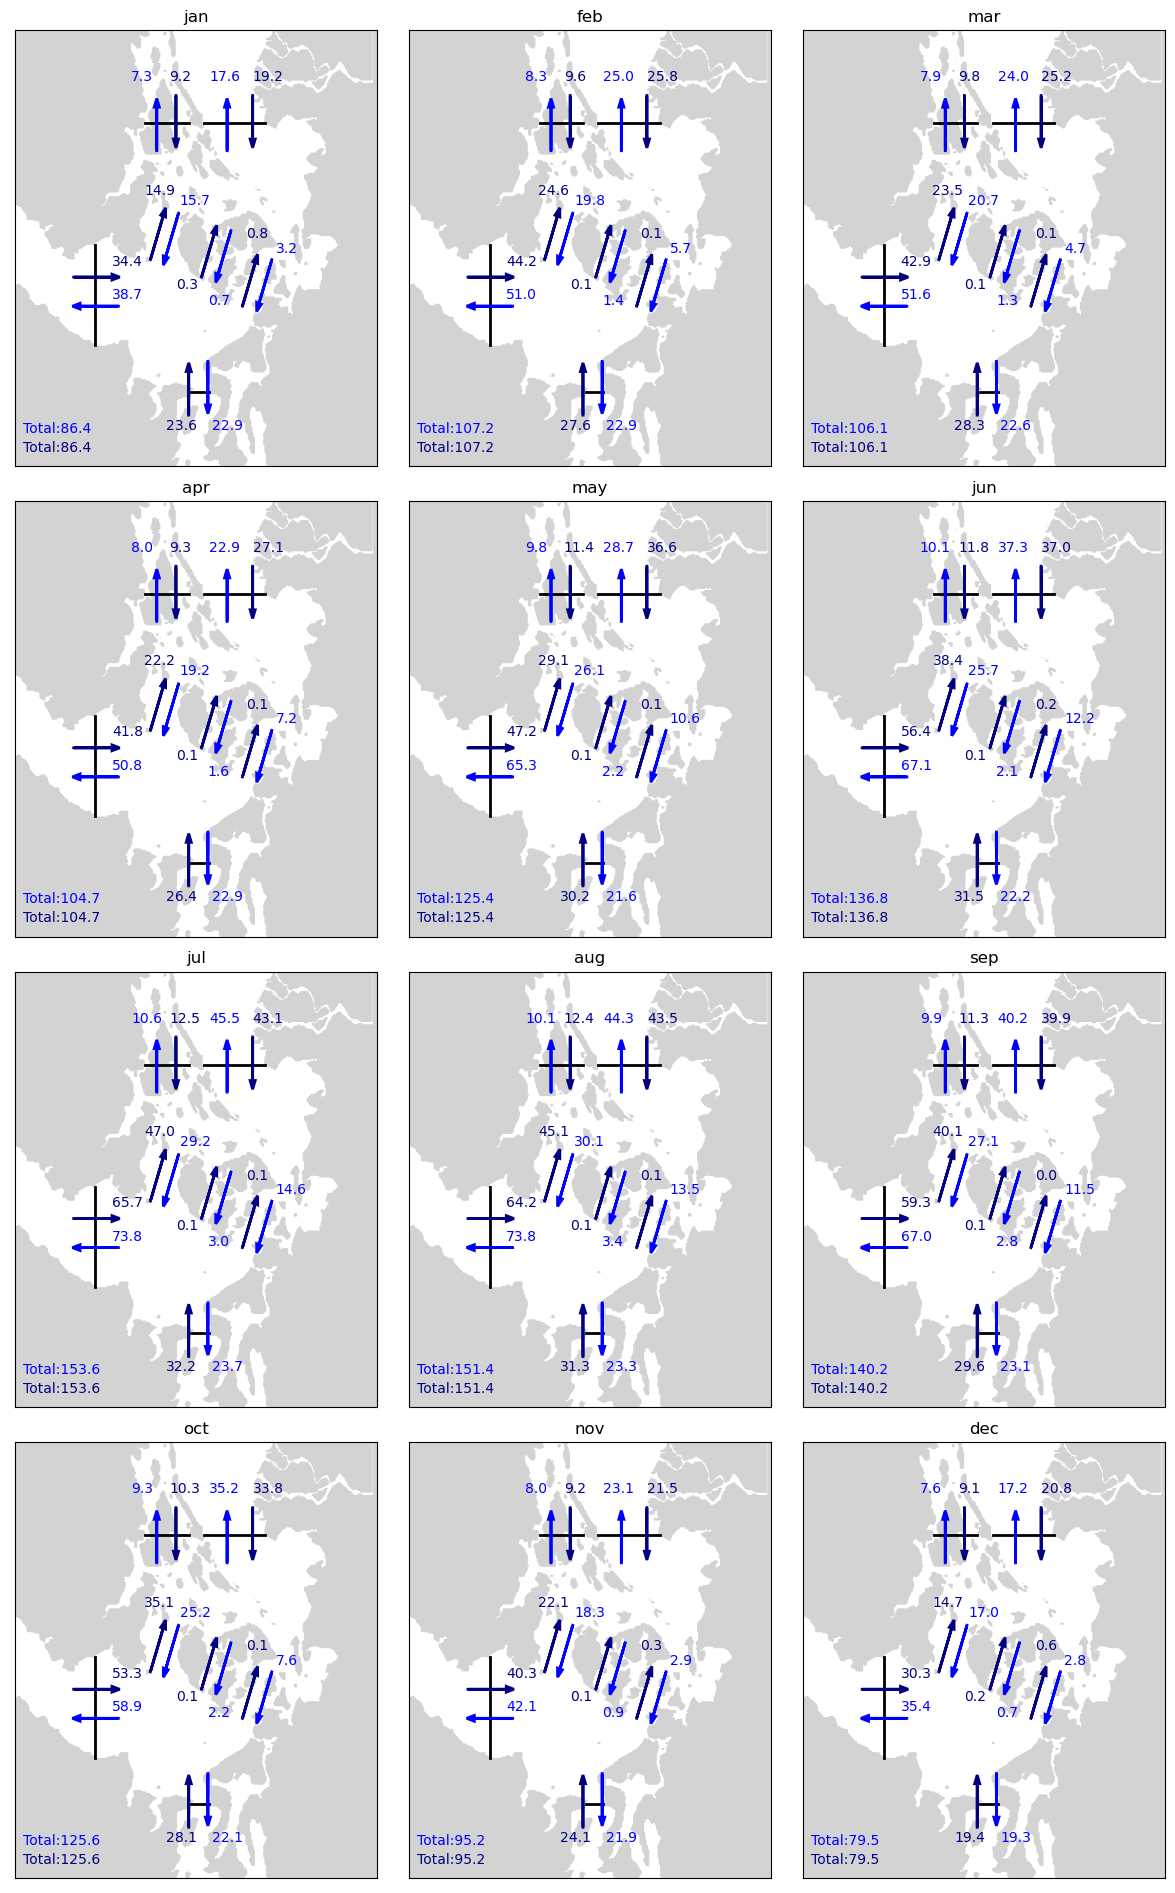

In [323]:
vs_y = np.arange(233,303,1)
vs_x = np.linspace(177,177,len(vs_y))
adm_x = np.arange(252,267,1)
adm_y = np.linspace(201,201,len(adm_x))
pr_x = np.arange(262,311,1)
pr_y = np.linspace(386,386,len(pr_x))
gulf_x = np.arange(216,251,1)
gulf_y = np.linspace(386,386,len(gulf_x))

months = ['jan','feb','mar','apr','may','jun','jul','aug','sep','oct','nov','dec']
lw = 2

subdomain = [114, 397, 150, 450]
fig,[[ax1,ax2,ax3],[ax4,ax5,ax6],[ax7,ax8,ax9],[ax10,ax11,ax12]] = plt.subplots(4,3,figsize=(18, 24))

for ii,ax in enumerate([ax1,ax2,ax3,ax4,ax5,ax6,ax7,ax8,ax9,ax10,ax11,ax12]):
    for attr, color in zip(['contourf', 'contour'], ['lightgray', 'lightgrey']):
        getattr(ax, attr)(mesh.tmask[0, 0, ...],levels=[-0.01,0.01], colors=color) #If 0 -> contour f makes all that are 0 grey. contour makes the transition to 0 black

    ax.set_xlim(subdomain[:2])
    ax.set_ylim(subdomain[2:])
    # ax.set_xlabel('Grid X')
    # ax.set_ylabel('Grid Y')
    ax.set_xticks([])
    ax.set_yticks([])
    viz_tools.set_aspect(ax);

    ax.plot(vs_x,vs_y,color='k',lw=2)
    ax.plot(adm_x,adm_y,color='k',lw=2)
    ax.plot(pr_x,pr_y,color='k',lw=2)
    ax.plot(gulf_x,gulf_y,color='k',lw=2)

    #VicSill arrows
    ax.text(190, 288, '{:.1f}'.format(float(np.round(leave_vic[ii] / 1000, 1))),color='navy')
    ax.text(190, 265, '{:.1f}'.format(float(np.round(ent_vic[ii] / 1000, 1))),color='blue')
    ax.arrow(160, 280, 30, 0, head_width=4, edgecolor='navy', facecolor='navy', zorder=10,lw=lw)
    ax.arrow(195, 260, -30, 0, head_width=4, edgecolor='blue', facecolor='blue', zorder=10,lw=lw)

    #PointRob arrows
    ax.text(266, 415, '{:.1f}'.format(float(np.round(ent_pr[ii] / 1000, 1))),color='blue')
    ax.text(300, 415, '{:.1f}'.format(float(np.round(leave_pr[ii] / 1000, 1))),color='navy')
    ax.arrow(280, 367, 0, 30, head_width=4, edgecolor='blue', facecolor='blue', zorder=10,lw=lw)
    ax.arrow(300, 405, 0, -30, head_width=4, edgecolor='navy', facecolor='navy', zorder=10,lw=lw)

    #Gulf arrows
    ax.text(205, 415, '{:.1f}'.format(float(np.round(ent_gulf[ii] / 1000, 1))),color='blue')
    ax.text(235, 415, '{:.1f}'.format(float(np.round(leave_gulf[ii] / 1000, 1))),color='navy')
    ax.arrow(225, 367, 0, 30, head_width=4, edgecolor='blue', facecolor='blue', zorder=10,lw=lw)
    ax.arrow(240, 405, 0, -30, head_width=4, edgecolor='navy', facecolor='navy', zorder=10,lw=lw)

    #Adm arrows
    ax.text(232, 175, '{:.1f}'.format(float(np.round(leave_adm[ii] / 1000, 1))),color='navy')
    ax.text(268, 175, '{:.1f}'.format(float(np.round(ent_adm[ii] / 1000, 1))),color='blue')
    ax.arrow(250, 185, 0, 30, head_width=4, edgecolor='navy', facecolor='navy', zorder=10,lw=lw)
    ax.arrow(265, 222, 0, -30, head_width=4, edgecolor='blue', facecolor='blue', zorder=10,lw=lw)

    #Haro arrows
    ax.text(215, 337, '{:.1f}'.format(float(np.round(N_haro[ii] / 1000, 1))),color='navy')
    ax.text(243, 330, '{:.1f}'.format(float(np.round(S_haro[ii] / 1000, 1))),color='blue')
    ax.arrow(220, 292, 10, 30, head_width=4, edgecolor='navy', facecolor='navy', zorder=10,lw=lw)
    ax.arrow(242, 324, -10, -30, head_width=4, edgecolor='blue', facecolor='blue', zorder=10,lw=lw)

    # #SJC arrows
    ax.text(240, 272, '{:.1f}'.format(float(np.round(N_sjc[ii] / 1000, 1))),color='navy')
    ax.text(265, 261, '{:.1f}'.format(float(np.round(S_sjc[ii] / 1000, 1))),color='blue')
    ax.arrow(260, 280, 10, 30, head_width=4, edgecolor='navy', facecolor='navy', zorder=10,lw=lw)
    ax.arrow(283, 312, -10, -30, head_width=4, edgecolor='blue', facecolor='blue', zorder=10,lw=lw)

    # #Rosario arrows
    ax.text(295, 307, '{:.1f}'.format(float(np.round(N_ros[ii] / 1000, 1))),color='navy')
    ax.text(318, 297, '{:.1f}'.format(float(np.round(S_ros[ii] / 1000, 1))),color='blue')
    ax.arrow(292, 260, 10, 30, head_width=4, edgecolor='navy', facecolor='navy', zorder=10,lw=lw)
    ax.arrow(315, 292, -10, -30, head_width=4, edgecolor='blue', facecolor='blue', zorder=10,lw=lw)
    
    #Total
    ax.text(120, 160, 'Total:'+ '{:.1f}'.format(float(np.round(ent_total[ii] / 1000, 1))),color='navy')
    ax.text(120, 173, 'Total:'+ '{:.1f}'.format(float(np.round(leave_total[ii] / 1000, 1))),color='blue')
    
    ax.set_title(months[ii])

fig.subplots_adjust(hspace=0.08,wspace=-0.35)

(170.0, 450.0)

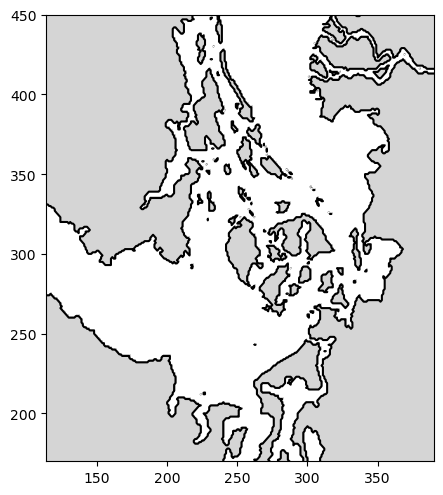

In [65]:
cmap = cma.gist_gray
cmap.set_bad('white')
fig, ax = plt.subplots(1, 1, figsize=(5, 9))

for attr, color in zip(['contourf', 'contour'], ['lightgray', 'k']):
    getattr(ax, attr)(mesh.tmask[0, 0, ...],levels=[-0.01,0.01], colors=color) 
    
ma_arr = np.ma.masked_array(np.zeros([898,398]), mask=mesh.tmask[0,0])
colours = ax.pcolormesh(ma_arr, cmap=cmap,vmin=-5, vmax=1)
# cb = fig.colorbar(colours, ax=ax,shrink=0.5)
# cb.set_label('Salinity (g/kg)')
viz_tools.set_aspect(ax);
ax.set_xlim([114,390])
ax.set_ylim([170,450])